In [1]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite

In [9]:
SN_Array = composite.grab("SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN")

4826 spectra found
Arrays cleaned


In [3]:
event_dict = {}
for i in range(len(SN_Array)):
    if event_dict.get(SN_Array[i].name) is None:
        event_dict[SN_Array[i].name] = [SN_Array[i]]
    else:
        event_dict[SN_Array[i].name] = event_dict.get(SN_Array[i].name) + [SN_Array[i]]

In [4]:
%matplotlib inline

In [5]:
spec_per_sn = []
dm15_dist = []
phase_dist = []
morph_dist = []
for SN in event_dict.keys():
    spec_per_sn.append(len(event_dict[SN]))
    if event_dict[SN][0].dm15_cfa != None:
        dm15_dist.append(event_dict[SN][0].dm15_cfa)
    elif event_dict[SN][0].dm15_from_fits != None:
        dm15_dist.append(event_dict[SN][0].dm15_from_fits)
    if event_dict[SN][0].morph != None and event_dict[SN][0].morph > 0:
        morph_dist.append(event_dict[SN][0].morph)
    
    for spec in event_dict[SN]:
        if spec.phase != None:
            phase_dist.append(spec.phase)

In [6]:
print len(event_dict.keys())

751


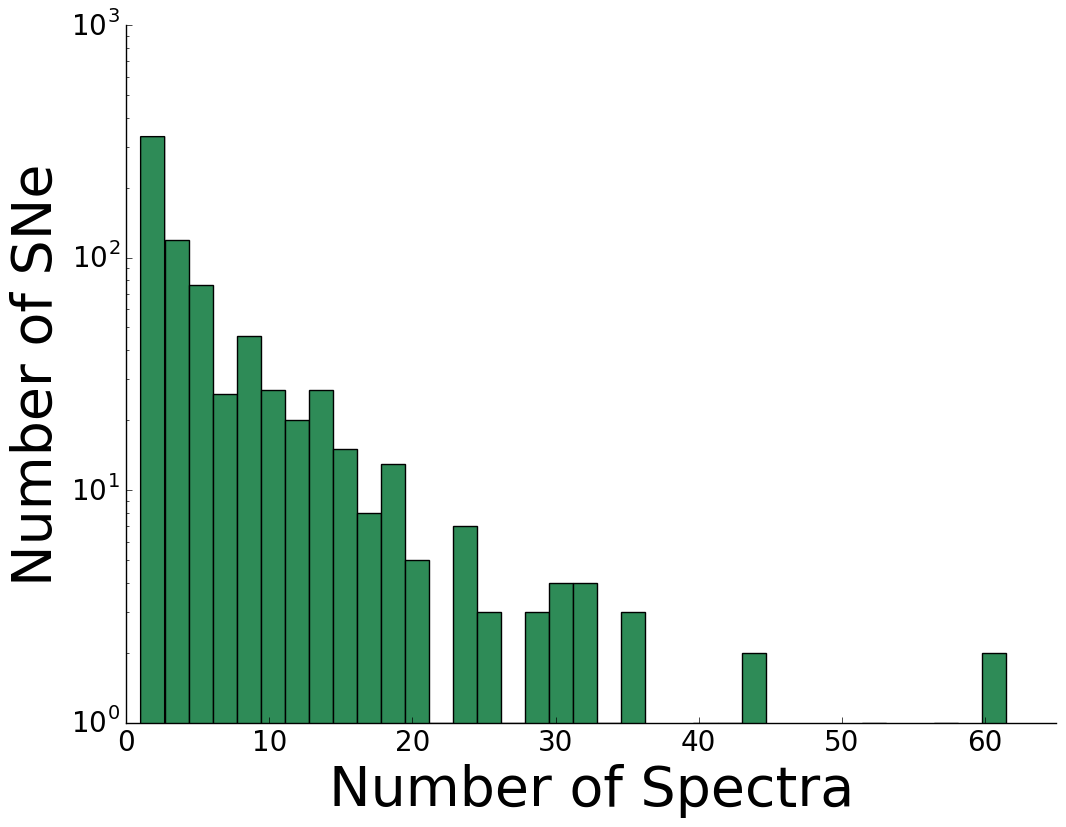

In [7]:
plt.figure(figsize=(12, 9)) 
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Number of Spectra", fontsize=40)  
plt.xlim([0,65])
plt.ylabel("Number of SNe", fontsize=40)  
plt.hist(spec_per_sn, bins = 50, color="seagreen",log = True)
# plt.savefig('../../Paper_Drafts/spec_per_sn.png', dpi = 300, bbox_inches = 'tight')
plt.show()

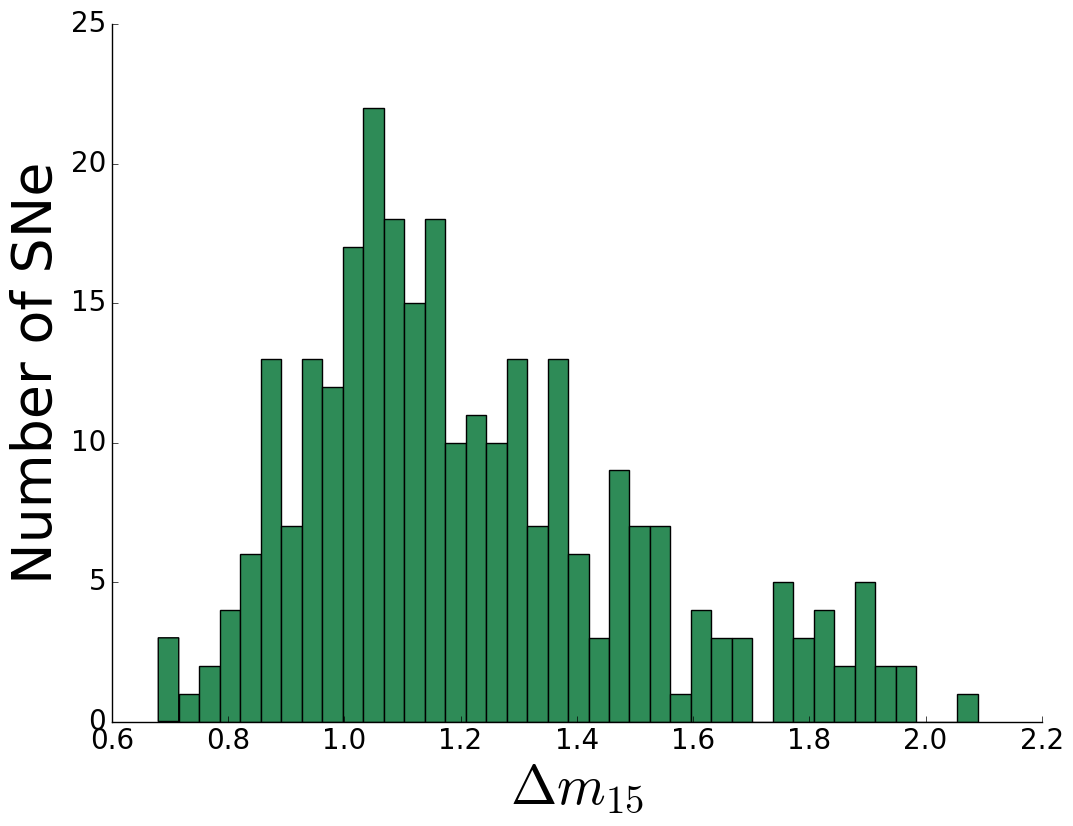

In [58]:
plt.figure(figsize=(12, 9)) 
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("$\Delta m_{15}$", fontsize=40)  
plt.ylabel("Number of SNe", fontsize=40)  
plt.hist(dm15_dist, bins = 40, color="seagreen")
# plt.savefig('../../Paper_Drafts/dm15_dist.png', dpi = 300, bbox_inches = 'tight')
plt.show()

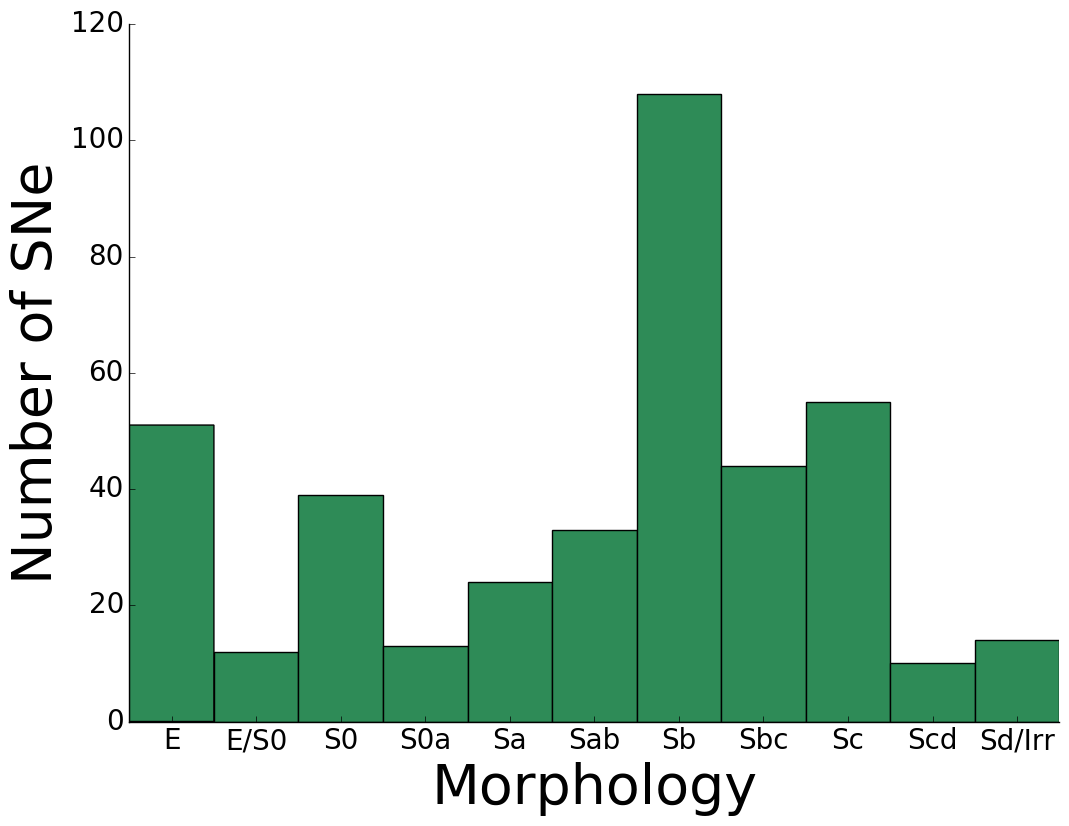

In [59]:
plt.figure(figsize=(12, 9)) 
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

x = [1,2,3,4,5,6,7,8,9,10,11]
labels = ['E','E/S0','S0','S0a','Sa','Sab','Sb','Sbc','Sc','Scd','Sd/Irr']
plt.xticks(x, labels, fontsize = 20)
plt.yticks(fontsize = 20)

plt.xlabel("Morphology", fontsize=40)  
plt.ylabel("Number of SNe", fontsize=40)  
plt.hist(morph_dist,bins=[.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5],  color="seagreen")
# plt.savefig('../../FOE_figures/morph_dist.png', dpi = 300, bbox_inches = 'tight')
plt.show()

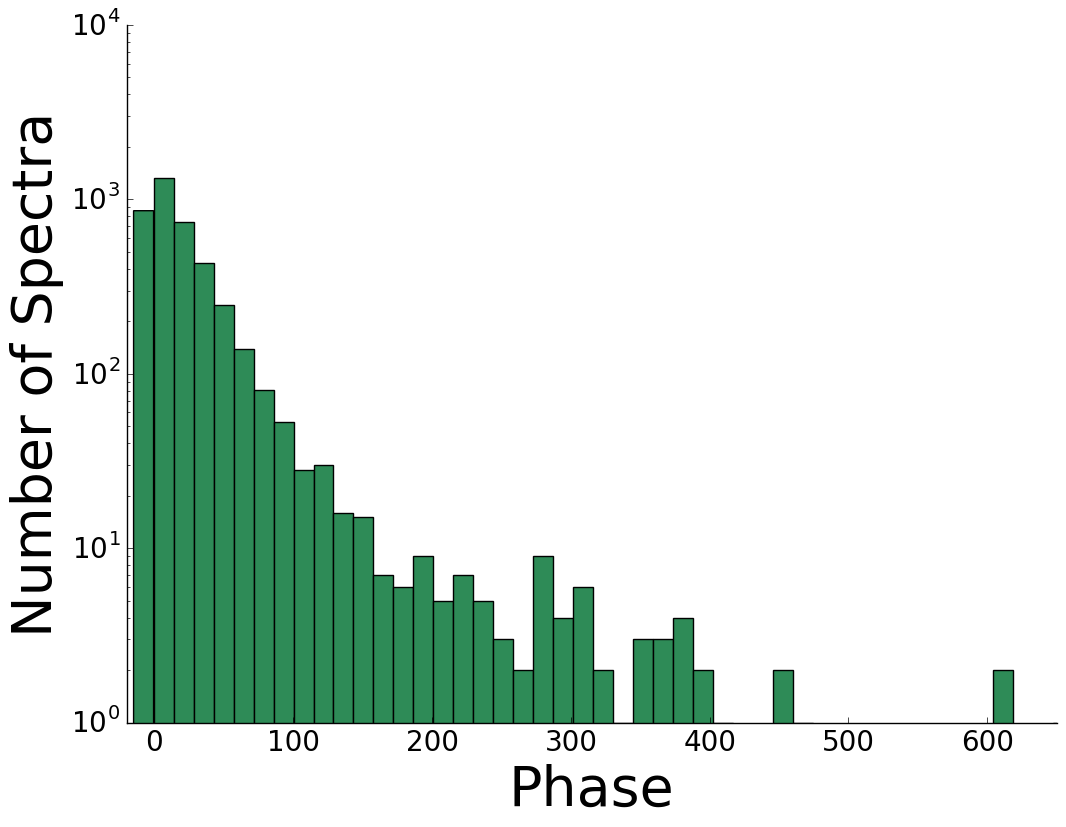

In [60]:
plt.figure(figsize=(12, 9)) 
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
plt.xlabel("Phase", fontsize=40)  
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim([-20,650])
plt.ylabel("Number of Spectra", fontsize=40)  
plt.hist(phase_dist, bins = 70, color="seagreen", log = True)
# plt.savefig('../../Paper_Drafts/phase_dist.png', dpi = 300, bbox_inches = 'tight')
plt.show()